# Model Performance Test


In [24]:
from dtsp.dataset import walk_forward_split, Seq2SeqDataSet, SimpleSeq2SeqDataSet, SimpleWaveNetDataSet
from dtsp.models import Seq2Seq, SimpleSeq2Seq, SimpleWaveNet
from torch.utils.data import DataLoader
from torch.utils.data import Subset, DataLoader
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from pathlib import Path
import shutil
import seaborn as sns

%matplotlib inline

def plot_attentions(attns):
    if attns.ndim == 4:
        assert attns.shape[0] == 1
        attns = attns.squeeze(0)
    if isinstance(attns, torch.Tensor):
        attns = attns.detach().numpy()
    n_head = attns.shape[1]
    
    base_size = 12
    
    hight = attns.shape[0]
    wide = attns.shape[2]
    for i in range(n_head):
        plt.figure(figsize=(16, hight / wide * 16))
        sns.heatmap(attns[:, i, :])
        plt.title(f"Attention {i}")
        plt.xlabel('history')
        plt.ylabel('prediction')


def plot_prediction(enc, y_pred, y_true):
    f = plt.figure(figsize=(12, 4))
    enc_lens = len(enc)
    dec_lens = len(y_pred)
    plt.plot(enc)
    plt.plot(range(enc_lens, enc_lens+dec_lens), y_pred, label='prediction', linestyle='--')
    plt.plot(range(enc_lens, enc_lens+dec_lens), y_true, label='true')
    plt.legend()

In [2]:
torch.__version__

'1.3.0'

## 1. prepare dataset

In [3]:
df = pd.read_csv('./data.csv', index_col='date_time', parse_dates=['date_time'])
series = df.values
month = df.index.month.values
df.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
date_time,,,,,,,,,,,,,,,,,,,,
1998-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0
1998-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0,0,0.0,0


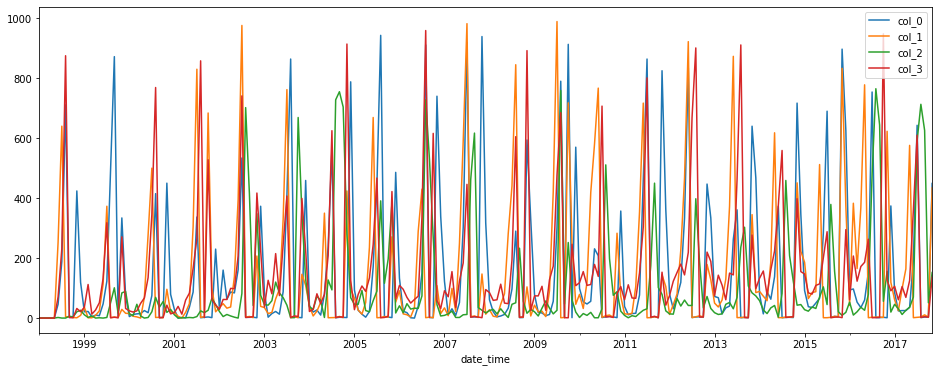

In [4]:
df.iloc[:, :4].plot(figsize=(16, 6))

**Target**

In [5]:
n_test = 12
n_val = 12
enc_lens = 72
dec_lens = 12
batch_size = 8
epochs = 50

## 1. Simple Seq2Seq Model

In [6]:
dataset = SimpleSeq2SeqDataSet(series, enc_lens, dec_lens)
idxes = list(range(len(dataset)))
train_idxes, _idxes = walk_forward_split(idxes, enc_lens, dec_lens, test_size=n_test + n_val)
valid_idxes, test_idxes = walk_forward_split(_idxes, enc_lens, dec_lens, test_size=n_test)

trn_set = Subset(dataset, train_idxes)
val_set = Subset(dataset, valid_idxes)
test_set = Subset(dataset, test_idxes)
trn_ld = DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_ld = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_ld = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [7]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.2,
        'hidden_size': 72,
        'teacher_forcing_rate': 0.5,
        'learning_rate': 0.001,
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = SimpleSeq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 0.927: 100%|██████████| 17/17 [00:00<00:00, 18.45it/s]


epoch 1 / 50: train loss 1.081 val loss 1.205 RMSE 182.256
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.808: 100%|██████████| 17/17 [00:00<00:00, 19.52it/s]


epoch 2 / 50: train loss 1.013 val loss 1.075 RMSE 173.407


batch 17 / 17, loss 0.856: 100%|██████████| 17/17 [00:00<00:00, 19.77it/s]


epoch 3 / 50: train loss 0.862 val loss 0.959 RMSE 167.003


batch 17 / 17, loss 0.620: 100%|██████████| 17/17 [00:00<00:00, 20.10it/s]


epoch 4 / 50: train loss 0.809 val loss 0.945 RMSE 165.161


batch 17 / 17, loss 0.688: 100%|██████████| 17/17 [00:00<00:00, 19.61it/s]


epoch 5 / 50: train loss 0.805 val loss 0.942 RMSE 164.917


batch 17 / 17, loss 1.000: 100%|██████████| 17/17 [00:00<00:00, 20.12it/s]


epoch 6 / 50: train loss 0.782 val loss 0.894 RMSE 159.886


batch 17 / 17, loss 0.719: 100%|██████████| 17/17 [00:00<00:00, 19.19it/s]


epoch 7 / 50: train loss 0.724 val loss 0.834 RMSE 153.356


batch 17 / 17, loss 0.627: 100%|██████████| 17/17 [00:00<00:00, 20.59it/s]


epoch 8 / 50: train loss 0.688 val loss 0.890 RMSE 159.492


batch 17 / 17, loss 0.885: 100%|██████████| 17/17 [00:00<00:00, 20.84it/s]


epoch 9 / 50: train loss 0.691 val loss 0.985 RMSE 168.839


batch 17 / 17, loss 0.523: 100%|██████████| 17/17 [00:00<00:00, 21.17it/s]


epoch 10 / 50: train loss 0.689 val loss 0.957 RMSE 164.356


batch 17 / 17, loss 0.767: 100%|██████████| 17/17 [00:00<00:00, 18.92it/s]


epoch 11 / 50: train loss 0.691 val loss 0.815 RMSE 150.725


batch 17 / 17, loss 0.634: 100%|██████████| 17/17 [00:00<00:00, 19.33it/s]


epoch 12 / 50: train loss 0.661 val loss 0.804 RMSE 149.508


batch 17 / 17, loss 0.655: 100%|██████████| 17/17 [00:00<00:00, 19.19it/s]


epoch 13 / 50: train loss 0.642 val loss 0.804 RMSE 148.655


batch 17 / 17, loss 0.881: 100%|██████████| 17/17 [00:00<00:00, 18.96it/s]


epoch 14 / 50: train loss 0.627 val loss 0.787 RMSE 147.762


batch 17 / 17, loss 0.515: 100%|██████████| 17/17 [00:00<00:00, 20.10it/s]


epoch 15 / 50: train loss 0.614 val loss 0.777 RMSE 146.179


batch 17 / 17, loss 0.683: 100%|██████████| 17/17 [00:00<00:00, 19.89it/s]


epoch 16 / 50: train loss 0.595 val loss 0.766 RMSE 145.453


batch 17 / 17, loss 0.550: 100%|██████████| 17/17 [00:00<00:00, 20.29it/s]


epoch 17 / 50: train loss 0.572 val loss 0.757 RMSE 144.277


batch 17 / 17, loss 0.713: 100%|██████████| 17/17 [00:00<00:00, 20.27it/s]


epoch 18 / 50: train loss 0.574 val loss 0.747 RMSE 143.792


batch 17 / 17, loss 0.518: 100%|██████████| 17/17 [00:00<00:00, 19.80it/s]


epoch 19 / 50: train loss 0.564 val loss 0.740 RMSE 142.905


batch 17 / 17, loss 0.475: 100%|██████████| 17/17 [00:00<00:00, 19.71it/s]


epoch 20 / 50: train loss 0.541 val loss 0.741 RMSE 143.303


batch 17 / 17, loss 0.636: 100%|██████████| 17/17 [00:00<00:00, 19.26it/s]


epoch 21 / 50: train loss 0.529 val loss 0.746 RMSE 143.856


batch 17 / 17, loss 0.437: 100%|██████████| 17/17 [00:00<00:00, 19.19it/s]


epoch 22 / 50: train loss 0.542 val loss 0.738 RMSE 143.276


batch 17 / 17, loss 0.590: 100%|██████████| 17/17 [00:00<00:00, 20.01it/s]


epoch 23 / 50: train loss 0.528 val loss 0.728 RMSE 141.388


batch 17 / 17, loss 0.475: 100%|██████████| 17/17 [00:00<00:00, 18.96it/s]


epoch 24 / 50: train loss 0.519 val loss 0.723 RMSE 140.990


batch 17 / 17, loss 0.579: 100%|██████████| 17/17 [00:00<00:00, 18.04it/s]


epoch 25 / 50: train loss 0.515 val loss 0.721 RMSE 141.279


batch 17 / 17, loss 0.508: 100%|██████████| 17/17 [00:00<00:00, 18.06it/s]


epoch 26 / 50: train loss 0.513 val loss 0.713 RMSE 139.931


batch 17 / 17, loss 0.440: 100%|██████████| 17/17 [00:00<00:00, 18.21it/s]


epoch 27 / 50: train loss 0.505 val loss 0.720 RMSE 140.305


batch 17 / 17, loss 0.593: 100%|██████████| 17/17 [00:00<00:00, 20.05it/s]


epoch 28 / 50: train loss 0.499 val loss 0.703 RMSE 139.700


batch 17 / 17, loss 0.558: 100%|██████████| 17/17 [00:00<00:00, 20.01it/s]


epoch 29 / 50: train loss 0.495 val loss 0.731 RMSE 141.538


batch 17 / 17, loss 0.421: 100%|██████████| 17/17 [00:00<00:00, 19.77it/s]


epoch 30 / 50: train loss 0.497 val loss 0.700 RMSE 138.215


batch 17 / 17, loss 0.397: 100%|██████████| 17/17 [00:00<00:00, 20.94it/s]


epoch 31 / 50: train loss 0.469 val loss 0.686 RMSE 136.929


batch 17 / 17, loss 0.450: 100%|██████████| 17/17 [00:00<00:00, 19.55it/s]


epoch 32 / 50: train loss 0.479 val loss 0.693 RMSE 137.795


batch 17 / 17, loss 0.429: 100%|██████████| 17/17 [00:00<00:00, 19.96it/s]


epoch 33 / 50: train loss 0.459 val loss 0.685 RMSE 136.556


batch 17 / 17, loss 0.530: 100%|██████████| 17/17 [00:00<00:00, 19.64it/s]


epoch 34 / 50: train loss 0.478 val loss 0.678 RMSE 136.255


batch 17 / 17, loss 0.428: 100%|██████████| 17/17 [00:00<00:00, 19.77it/s]


epoch 35 / 50: train loss 0.471 val loss 0.681 RMSE 135.772


batch 17 / 17, loss 0.435: 100%|██████████| 17/17 [00:00<00:00, 21.31it/s]


epoch 36 / 50: train loss 0.425 val loss 0.671 RMSE 135.304


batch 17 / 17, loss 0.475: 100%|██████████| 17/17 [00:00<00:00, 18.92it/s]


epoch 37 / 50: train loss 0.463 val loss 0.674 RMSE 135.275


batch 17 / 17, loss 0.410: 100%|██████████| 17/17 [00:00<00:00, 19.71it/s]


epoch 38 / 50: train loss 0.447 val loss 0.665 RMSE 134.278


batch 17 / 17, loss 0.377: 100%|██████████| 17/17 [00:00<00:00, 19.26it/s]


epoch 39 / 50: train loss 0.451 val loss 0.662 RMSE 133.897


batch 17 / 17, loss 0.369: 100%|██████████| 17/17 [00:00<00:00, 19.75it/s]


epoch 40 / 50: train loss 0.456 val loss 0.656 RMSE 133.369


batch 17 / 17, loss 0.364: 100%|██████████| 17/17 [00:00<00:00, 20.08it/s]


epoch 41 / 50: train loss 0.429 val loss 0.654 RMSE 132.897


batch 17 / 17, loss 0.427: 100%|██████████| 17/17 [00:00<00:00, 19.35it/s]


epoch 42 / 50: train loss 0.439 val loss 0.659 RMSE 133.905


batch 17 / 17, loss 0.347: 100%|██████████| 17/17 [00:00<00:00, 20.39it/s]


epoch 43 / 50: train loss 0.420 val loss 0.651 RMSE 132.674


batch 17 / 17, loss 0.489: 100%|██████████| 17/17 [00:00<00:00, 20.36it/s]


epoch 44 / 50: train loss 0.427 val loss 0.657 RMSE 133.536


batch 17 / 17, loss 0.495: 100%|██████████| 17/17 [00:00<00:00, 20.22it/s]


epoch 45 / 50: train loss 0.438 val loss 0.651 RMSE 132.651


batch 17 / 17, loss 0.503: 100%|██████████| 17/17 [00:00<00:00, 18.92it/s]


epoch 46 / 50: train loss 0.449 val loss 0.651 RMSE 132.710


batch 17 / 17, loss 0.323: 100%|██████████| 17/17 [00:00<00:00, 19.52it/s]


epoch 47 / 50: train loss 0.440 val loss 0.649 RMSE 132.594


batch 17 / 17, loss 0.458: 100%|██████████| 17/17 [00:00<00:00, 20.12it/s]


epoch 48 / 50: train loss 0.413 val loss 0.647 RMSE 132.485


batch 17 / 17, loss 0.424: 100%|██████████| 17/17 [00:00<00:00, 20.20it/s]


epoch 49 / 50: train loss 0.425 val loss 0.647 RMSE 132.392


batch 17 / 17, loss 0.391: 100%|██████████| 17/17 [00:00<00:00, 20.01it/s]


epoch 50 / 50: train loss 0.420 val loss 0.647 RMSE 132.406
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\SimpleSeq2Seq_epoch_48_0.647.pkl


In [8]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.445, valid loss: 0.647, test loss :0.700, test RMSE :137.671, 


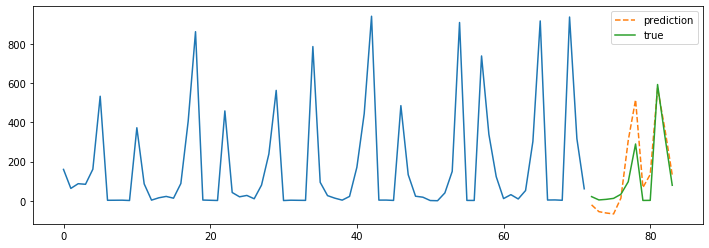

In [49]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])

## 2. Seq2Seq(Attention 0)

In [50]:
dataset = Seq2SeqDataSet(series, enc_lens, dec_lens, categorical_var=month)
idxes = list(range(len(dataset)))
train_idxes, _idxes = walk_forward_split(idxes, enc_lens, dec_lens, test_size=n_test + n_val)
valid_idxes, test_idxes = walk_forward_split(_idxes, enc_lens, dec_lens, test_size=n_test)

trn_set = Subset(dataset, train_idxes)
val_set = Subset(dataset, valid_idxes)
test_set = Subset(dataset, test_idxes)
trn_ld = DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_ld = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_ld = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [51]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.1,
        'hidden_size': 128,
        'teacher_forcing_rate': 0.5,
        'n_head': 4,
        'use_attn': False,
        'trans_hidden_size': 4,
        'trans_continuous_var': None,
        'trans_category_var': [(13, 2)],
        'trans_bidirectional': True,
        'trans_rnn_type': 'LSTM',
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = Seq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 1.172: 100%|██████████| 17/17 [00:02<00:00,  8.10it/s]


epoch 1 / 50: train loss 1.056 val loss 1.115 RMSE 176.163
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.978: 100%|██████████| 17/17 [00:02<00:00,  7.85it/s]


epoch 2 / 50: train loss 0.863 val loss 0.961 RMSE 166.585


batch 17 / 17, loss 0.637: 100%|██████████| 17/17 [00:02<00:00,  7.99it/s]


epoch 3 / 50: train loss 0.781 val loss 0.917 RMSE 162.712


batch 17 / 17, loss 0.983: 100%|██████████| 17/17 [00:02<00:00,  7.59it/s]


epoch 4 / 50: train loss 0.769 val loss 0.889 RMSE 160.004


batch 17 / 17, loss 0.640: 100%|██████████| 17/17 [00:02<00:00,  8.07it/s]


epoch 5 / 50: train loss 0.745 val loss 0.884 RMSE 159.448


batch 17 / 17, loss 0.623: 100%|██████████| 17/17 [00:02<00:00,  8.23it/s]


epoch 6 / 50: train loss 0.710 val loss 0.850 RMSE 154.254


batch 17 / 17, loss 0.600: 100%|██████████| 17/17 [00:02<00:00,  8.09it/s]


epoch 7 / 50: train loss 0.702 val loss 0.819 RMSE 151.032


batch 17 / 17, loss 0.536: 100%|██████████| 17/17 [00:02<00:00,  7.92it/s]


epoch 8 / 50: train loss 0.660 val loss 0.812 RMSE 150.339


batch 17 / 17, loss 0.791: 100%|██████████| 17/17 [00:02<00:00,  8.15it/s]


epoch 9 / 50: train loss 0.637 val loss 0.935 RMSE 162.931


batch 17 / 17, loss 0.615: 100%|██████████| 17/17 [00:02<00:00,  8.01it/s]


epoch 10 / 50: train loss 0.637 val loss 0.794 RMSE 149.179


batch 17 / 17, loss 0.480: 100%|██████████| 17/17 [00:02<00:00,  8.09it/s]


epoch 11 / 50: train loss 0.584 val loss 0.786 RMSE 146.722


batch 17 / 17, loss 0.470: 100%|██████████| 17/17 [00:02<00:00,  7.85it/s]


epoch 12 / 50: train loss 0.582 val loss 0.810 RMSE 150.450


batch 17 / 17, loss 0.641: 100%|██████████| 17/17 [00:02<00:00,  7.79it/s]


epoch 13 / 50: train loss 0.618 val loss 0.752 RMSE 144.029


batch 17 / 17, loss 0.530: 100%|██████████| 17/17 [00:02<00:00,  8.08it/s]


epoch 14 / 50: train loss 0.577 val loss 0.799 RMSE 146.799


batch 17 / 17, loss 0.481: 100%|██████████| 17/17 [00:02<00:00,  7.94it/s]


epoch 15 / 50: train loss 0.553 val loss 0.787 RMSE 147.779


batch 17 / 17, loss 0.474: 100%|██████████| 17/17 [00:02<00:00,  8.00it/s]


epoch 16 / 50: train loss 0.537 val loss 0.727 RMSE 140.628


batch 17 / 17, loss 0.399: 100%|██████████| 17/17 [00:02<00:00,  8.07it/s]


epoch 17 / 50: train loss 0.485 val loss 0.730 RMSE 142.302


batch 17 / 17, loss 0.491: 100%|██████████| 17/17 [00:02<00:00,  7.92it/s]


epoch 18 / 50: train loss 0.519 val loss 0.737 RMSE 141.554


batch 17 / 17, loss 0.555: 100%|██████████| 17/17 [00:02<00:00,  7.92it/s]


epoch 19 / 50: train loss 0.501 val loss 0.701 RMSE 139.141


batch 17 / 17, loss 0.793: 100%|██████████| 17/17 [00:02<00:00,  7.89it/s]


epoch 20 / 50: train loss 0.482 val loss 0.697 RMSE 140.417


batch 17 / 17, loss 0.394: 100%|██████████| 17/17 [00:02<00:00,  7.98it/s]


epoch 21 / 50: train loss 0.463 val loss 0.730 RMSE 141.023


batch 17 / 17, loss 0.451: 100%|██████████| 17/17 [00:02<00:00,  7.85it/s]


epoch 22 / 50: train loss 0.436 val loss 0.730 RMSE 141.797


batch 17 / 17, loss 0.320: 100%|██████████| 17/17 [00:02<00:00,  7.93it/s]


epoch 23 / 50: train loss 0.462 val loss 0.668 RMSE 134.721


batch 17 / 17, loss 0.346: 100%|██████████| 17/17 [00:02<00:00,  7.74it/s]


epoch 24 / 50: train loss 0.438 val loss 0.663 RMSE 133.792


batch 17 / 17, loss 0.731: 100%|██████████| 17/17 [00:02<00:00,  7.52it/s]


epoch 25 / 50: train loss 0.418 val loss 0.645 RMSE 133.405


batch 17 / 17, loss 0.305: 100%|██████████| 17/17 [00:02<00:00,  7.70it/s]


epoch 26 / 50: train loss 0.412 val loss 0.645 RMSE 134.214


batch 17 / 17, loss 0.528: 100%|██████████| 17/17 [00:02<00:00,  7.88it/s]


epoch 27 / 50: train loss 0.389 val loss 0.616 RMSE 128.940


batch 17 / 17, loss 0.295: 100%|██████████| 17/17 [00:02<00:00,  7.83it/s]


epoch 28 / 50: train loss 0.371 val loss 0.608 RMSE 128.622


batch 17 / 17, loss 0.349: 100%|██████████| 17/17 [00:02<00:00,  7.48it/s]


epoch 29 / 50: train loss 0.362 val loss 0.601 RMSE 127.148


batch 17 / 17, loss 0.396: 100%|██████████| 17/17 [00:02<00:00,  7.84it/s]


epoch 30 / 50: train loss 0.358 val loss 0.581 RMSE 124.937


batch 17 / 17, loss 0.648: 100%|██████████| 17/17 [00:02<00:00,  7.95it/s]


epoch 31 / 50: train loss 0.362 val loss 0.570 RMSE 123.008


batch 17 / 17, loss 0.378: 100%|██████████| 17/17 [00:02<00:00,  7.43it/s]


epoch 32 / 50: train loss 0.347 val loss 0.553 RMSE 121.481


batch 17 / 17, loss 0.326: 100%|██████████| 17/17 [00:02<00:00,  7.73it/s]


epoch 33 / 50: train loss 0.344 val loss 0.549 RMSE 120.399


batch 17 / 17, loss 0.268: 100%|██████████| 17/17 [00:02<00:00,  7.99it/s]


epoch 34 / 50: train loss 0.325 val loss 0.540 RMSE 119.354


batch 17 / 17, loss 0.296: 100%|██████████| 17/17 [00:02<00:00,  7.96it/s]


epoch 35 / 50: train loss 0.311 val loss 0.532 RMSE 117.947


batch 17 / 17, loss 0.372: 100%|██████████| 17/17 [00:02<00:00,  7.97it/s]


epoch 36 / 50: train loss 0.310 val loss 0.527 RMSE 117.588


batch 17 / 17, loss 0.310: 100%|██████████| 17/17 [00:02<00:00,  8.04it/s]


epoch 37 / 50: train loss 0.302 val loss 0.522 RMSE 116.776


batch 17 / 17, loss 0.258: 100%|██████████| 17/17 [00:02<00:00,  8.22it/s]


epoch 38 / 50: train loss 0.281 val loss 0.518 RMSE 116.207


batch 17 / 17, loss 0.319: 100%|██████████| 17/17 [00:02<00:00,  7.55it/s]


epoch 39 / 50: train loss 0.303 val loss 0.518 RMSE 115.028


batch 17 / 17, loss 0.456: 100%|██████████| 17/17 [00:02<00:00,  8.02it/s]


epoch 40 / 50: train loss 0.282 val loss 0.512 RMSE 114.556


batch 17 / 17, loss 0.237: 100%|██████████| 17/17 [00:02<00:00,  7.42it/s]


epoch 41 / 50: train loss 0.287 val loss 0.512 RMSE 114.867


batch 17 / 17, loss 0.279: 100%|██████████| 17/17 [00:02<00:00,  8.14it/s]


epoch 42 / 50: train loss 0.268 val loss 0.500 RMSE 113.335


batch 17 / 17, loss 0.297: 100%|██████████| 17/17 [00:02<00:00,  7.89it/s]


epoch 43 / 50: train loss 0.270 val loss 0.503 RMSE 113.121


batch 17 / 17, loss 0.395: 100%|██████████| 17/17 [00:02<00:00,  7.85it/s]


epoch 44 / 50: train loss 0.273 val loss 0.499 RMSE 112.715


batch 17 / 17, loss 0.242: 100%|██████████| 17/17 [00:02<00:00,  8.10it/s]


epoch 45 / 50: train loss 0.275 val loss 0.495 RMSE 112.463


batch 17 / 17, loss 0.354: 100%|██████████| 17/17 [00:02<00:00,  7.92it/s]


epoch 46 / 50: train loss 0.264 val loss 0.494 RMSE 112.256


batch 17 / 17, loss 0.252: 100%|██████████| 17/17 [00:02<00:00,  7.92it/s]


epoch 47 / 50: train loss 0.252 val loss 0.495 RMSE 111.948


batch 17 / 17, loss 0.325: 100%|██████████| 17/17 [00:02<00:00,  7.95it/s]


epoch 48 / 50: train loss 0.274 val loss 0.494 RMSE 111.904


batch 17 / 17, loss 0.446: 100%|██████████| 17/17 [00:02<00:00,  7.85it/s]


epoch 49 / 50: train loss 0.274 val loss 0.492 RMSE 111.766


batch 17 / 17, loss 0.287: 100%|██████████| 17/17 [00:02<00:00,  7.64it/s]


epoch 50 / 50: train loss 0.266 val loss 0.489 RMSE 111.617
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\Seq2Seq_epoch_50_0.489.pkl


In [52]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.282, valid loss: 0.489, test loss :0.562, test RMSE :120.519, 


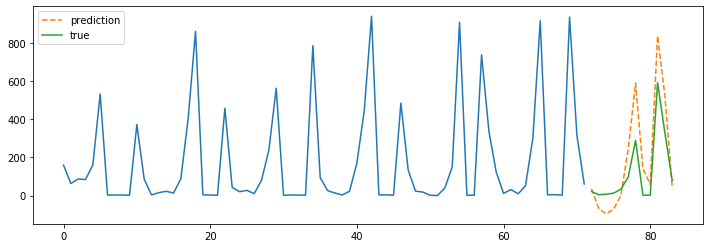

In [54]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
category_x = torch.tensor(val_set[k]['category_x']).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, category_x=category_x, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])

## 3. Seq2Seq(Attention 1)

In [55]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.1,
        'hidden_size': 128,
        'teacher_forcing_rate': 0.5,
        'n_head': 1,
        'use_attn': True,
        'trans_hidden_size': 4,
        'trans_continuous_var': None,
        'trans_category_var': [(13, 2)],
        'trans_bidirectional': True,
        'trans_rnn_type': 'LSTM',
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = Seq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 0.890: 100%|██████████| 17/17 [00:02<00:00,  7.53it/s]


epoch 1 / 50: train loss 1.067 val loss 1.157 RMSE 179.269
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.729: 100%|██████████| 17/17 [00:02<00:00,  7.66it/s]


epoch 2 / 50: train loss 0.867 val loss 0.962 RMSE 165.897


batch 17 / 17, loss 0.882: 100%|██████████| 17/17 [00:02<00:00,  7.39it/s]


epoch 3 / 50: train loss 0.799 val loss 0.913 RMSE 162.431


batch 17 / 17, loss 0.820: 100%|██████████| 17/17 [00:02<00:00,  7.38it/s]


epoch 4 / 50: train loss 0.757 val loss 0.885 RMSE 158.953


batch 17 / 17, loss 0.764: 100%|██████████| 17/17 [00:02<00:00,  7.76it/s]


epoch 5 / 50: train loss 0.735 val loss 0.879 RMSE 158.280


batch 17 / 17, loss 0.663: 100%|██████████| 17/17 [00:02<00:00,  7.89it/s]


epoch 6 / 50: train loss 0.694 val loss 0.841 RMSE 153.808


batch 17 / 17, loss 0.613: 100%|██████████| 17/17 [00:02<00:00,  7.71it/s]


epoch 7 / 50: train loss 0.662 val loss 0.875 RMSE 156.021


batch 17 / 17, loss 0.778: 100%|██████████| 17/17 [00:02<00:00,  7.60it/s]


epoch 8 / 50: train loss 0.695 val loss 0.951 RMSE 164.272


batch 17 / 17, loss 0.581: 100%|██████████| 17/17 [00:02<00:00,  7.74it/s]


epoch 9 / 50: train loss 0.677 val loss 0.794 RMSE 148.682


batch 17 / 17, loss 0.584: 100%|██████████| 17/17 [00:02<00:00,  7.76it/s]


epoch 10 / 50: train loss 0.618 val loss 0.771 RMSE 146.881


batch 17 / 17, loss 0.928: 100%|██████████| 17/17 [00:02<00:00,  7.48it/s]


epoch 11 / 50: train loss 0.588 val loss 0.742 RMSE 142.895


batch 17 / 17, loss 0.791: 100%|██████████| 17/17 [00:02<00:00,  7.88it/s]


epoch 12 / 50: train loss 0.563 val loss 0.786 RMSE 148.781


batch 17 / 17, loss 0.571: 100%|██████████| 17/17 [00:02<00:00,  7.60it/s]


epoch 13 / 50: train loss 0.578 val loss 0.779 RMSE 149.328


batch 17 / 17, loss 0.559: 100%|██████████| 17/17 [00:02<00:00,  7.60it/s]


epoch 14 / 50: train loss 0.532 val loss 0.726 RMSE 142.693


batch 17 / 17, loss 0.416: 100%|██████████| 17/17 [00:02<00:00,  7.53it/s]


epoch 15 / 50: train loss 0.531 val loss 0.754 RMSE 147.248


batch 17 / 17, loss 0.524: 100%|██████████| 17/17 [00:02<00:00,  7.61it/s]


epoch 16 / 50: train loss 0.506 val loss 0.697 RMSE 140.587


batch 17 / 17, loss 0.477: 100%|██████████| 17/17 [00:02<00:00,  7.73it/s]


epoch 17 / 50: train loss 0.468 val loss 0.673 RMSE 135.797


batch 17 / 17, loss 0.394: 100%|██████████| 17/17 [00:02<00:00,  7.50it/s]


epoch 18 / 50: train loss 0.459 val loss 0.675 RMSE 137.007


batch 17 / 17, loss 0.404: 100%|██████████| 17/17 [00:02<00:00,  7.67it/s]


epoch 19 / 50: train loss 0.433 val loss 0.651 RMSE 133.748


batch 17 / 17, loss 0.385: 100%|██████████| 17/17 [00:02<00:00,  7.60it/s]


epoch 20 / 50: train loss 0.416 val loss 0.634 RMSE 131.171


batch 17 / 17, loss 0.350: 100%|██████████| 17/17 [00:02<00:00,  7.61it/s]


epoch 21 / 50: train loss 0.420 val loss 0.630 RMSE 130.383


batch 17 / 17, loss 0.405: 100%|██████████| 17/17 [00:02<00:00,  7.50it/s]


epoch 22 / 50: train loss 0.408 val loss 0.608 RMSE 128.239


batch 17 / 17, loss 0.372: 100%|██████████| 17/17 [00:02<00:00,  7.52it/s]


epoch 23 / 50: train loss 0.394 val loss 0.629 RMSE 128.611


batch 17 / 17, loss 0.656: 100%|██████████| 17/17 [00:02<00:00,  7.56it/s]


epoch 24 / 50: train loss 0.387 val loss 0.596 RMSE 125.980


batch 17 / 17, loss 0.408: 100%|██████████| 17/17 [00:02<00:00,  7.40it/s]


epoch 25 / 50: train loss 0.365 val loss 0.576 RMSE 123.285


batch 17 / 17, loss 0.349: 100%|██████████| 17/17 [00:02<00:00,  7.63it/s]


epoch 26 / 50: train loss 0.337 val loss 0.592 RMSE 125.962


batch 17 / 17, loss 0.372: 100%|██████████| 17/17 [00:02<00:00,  7.18it/s]


epoch 27 / 50: train loss 0.352 val loss 0.571 RMSE 121.457


batch 17 / 17, loss 0.295: 100%|██████████| 17/17 [00:02<00:00,  7.41it/s]


epoch 28 / 50: train loss 0.337 val loss 0.558 RMSE 119.818


batch 17 / 17, loss 0.238: 100%|██████████| 17/17 [00:02<00:00,  7.75it/s]


epoch 29 / 50: train loss 0.316 val loss 0.565 RMSE 120.798


batch 17 / 17, loss 0.369: 100%|██████████| 17/17 [00:02<00:00,  7.61it/s]


epoch 30 / 50: train loss 0.331 val loss 0.595 RMSE 124.590


batch 17 / 17, loss 0.256: 100%|██████████| 17/17 [00:02<00:00,  7.59it/s]


epoch 31 / 50: train loss 0.311 val loss 0.546 RMSE 117.534


batch 17 / 17, loss 0.508: 100%|██████████| 17/17 [00:02<00:00,  7.72it/s]


epoch 32 / 50: train loss 0.328 val loss 0.568 RMSE 122.123


batch 17 / 17, loss 0.583: 100%|██████████| 17/17 [00:02<00:00,  7.84it/s]


epoch 33 / 50: train loss 0.323 val loss 0.611 RMSE 128.136


batch 17 / 17, loss 0.244: 100%|██████████| 17/17 [00:02<00:00,  7.42it/s]


epoch 34 / 50: train loss 0.298 val loss 0.516 RMSE 114.260


batch 17 / 17, loss 0.260: 100%|██████████| 17/17 [00:02<00:00,  6.30it/s]


epoch 35 / 50: train loss 0.281 val loss 0.511 RMSE 112.086


batch 17 / 17, loss 0.302: 100%|██████████| 17/17 [00:02<00:00,  7.48it/s]


epoch 36 / 50: train loss 0.266 val loss 0.498 RMSE 110.178


batch 17 / 17, loss 0.263: 100%|██████████| 17/17 [00:02<00:00,  7.07it/s]


epoch 37 / 50: train loss 0.262 val loss 0.494 RMSE 108.828


batch 17 / 17, loss 0.362: 100%|██████████| 17/17 [00:02<00:00,  7.13it/s]


epoch 38 / 50: train loss 0.260 val loss 0.487 RMSE 107.742


batch 17 / 17, loss 0.242: 100%|██████████| 17/17 [00:02<00:00,  7.11it/s]


epoch 39 / 50: train loss 0.262 val loss 0.482 RMSE 106.470


batch 17 / 17, loss 0.293: 100%|██████████| 17/17 [00:02<00:00,  7.49it/s]


epoch 40 / 50: train loss 0.249 val loss 0.475 RMSE 105.792


batch 17 / 17, loss 0.234: 100%|██████████| 17/17 [00:02<00:00,  6.54it/s]


epoch 41 / 50: train loss 0.239 val loss 0.475 RMSE 105.510


batch 17 / 17, loss 0.239: 100%|██████████| 17/17 [00:02<00:00,  7.06it/s]


epoch 42 / 50: train loss 0.232 val loss 0.471 RMSE 104.868


batch 17 / 17, loss 0.250: 100%|██████████| 17/17 [00:02<00:00,  7.62it/s]


epoch 43 / 50: train loss 0.236 val loss 0.471 RMSE 104.371


batch 17 / 17, loss 0.231: 100%|██████████| 17/17 [00:02<00:00,  6.62it/s]


epoch 44 / 50: train loss 0.233 val loss 0.467 RMSE 103.805


batch 17 / 17, loss 0.192: 100%|██████████| 17/17 [00:02<00:00,  7.73it/s]


epoch 45 / 50: train loss 0.231 val loss 0.464 RMSE 103.275


batch 17 / 17, loss 0.169: 100%|██████████| 17/17 [00:02<00:00,  8.01it/s]


epoch 46 / 50: train loss 0.225 val loss 0.466 RMSE 103.528


batch 17 / 17, loss 0.260: 100%|██████████| 17/17 [00:02<00:00,  7.55it/s]


epoch 47 / 50: train loss 0.226 val loss 0.461 RMSE 102.775


batch 17 / 17, loss 0.192: 100%|██████████| 17/17 [00:02<00:00,  7.86it/s]


epoch 48 / 50: train loss 0.214 val loss 0.466 RMSE 103.318


batch 17 / 17, loss 0.220: 100%|██████████| 17/17 [00:02<00:00,  7.67it/s]


epoch 49 / 50: train loss 0.223 val loss 0.463 RMSE 103.044


batch 17 / 17, loss 0.215: 100%|██████████| 17/17 [00:02<00:00,  7.52it/s]


epoch 50 / 50: train loss 0.224 val loss 0.460 RMSE 102.523
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\Seq2Seq_epoch_50_0.460.pkl


In [56]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.230, valid loss: 0.460, test loss :0.549, test RMSE :113.719, 


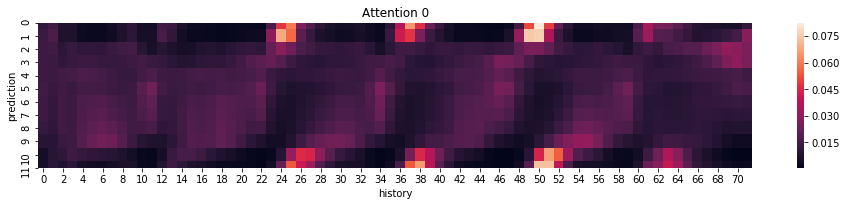

In [57]:
pred_idx = 200
enc_x = torch.tensor(series[pred_idx - enc_lens: pred_idx]).unsqueeze(0).float()
cat_x = torch.tensor(month[pred_idx-enc_lens: pred_idx + dec_lens]).unsqueeze(0).unsqueeze(2).long()
y_pred, attns = model.predict(enc_x, dec_lens, category_x=cat_x, use_move_scale=True, return_attns=True)
plot_attentions(attns)

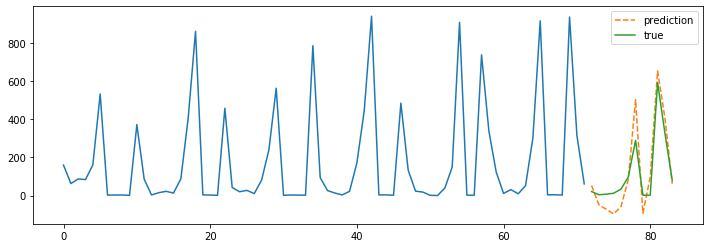

In [58]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
category_x = torch.tensor(val_set[k]['category_x']).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, category_x=category_x, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])

## 4. Seq2Seq(Attention 4)

In [62]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'rnn_type': 'LSTM',
        'dropout': 0.1,
        'hidden_size': 128,
        'teacher_forcing_rate': 0.5,
        'n_head': 4,
        'use_attn': True,
        'trans_hidden_size': 4,
        'trans_continuous_var': None,
        'trans_category_var': [(13, 2)],
        'trans_bidirectional': True,
        'trans_rnn_type': 'LSTM',
        'use_move_scale': True,
    }

compile_params = {
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
}

model = Seq2Seq(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 0.980: 100%|██████████| 17/17 [00:02<00:00,  6.64it/s]


epoch 1 / 50: train loss 1.070 val loss 1.138 RMSE 178.109
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.840: 100%|██████████| 17/17 [00:02<00:00,  6.81it/s]


epoch 2 / 50: train loss 0.871 val loss 0.966 RMSE 166.889


batch 17 / 17, loss 0.746: 100%|██████████| 17/17 [00:02<00:00,  6.21it/s]


epoch 3 / 50: train loss 0.813 val loss 0.919 RMSE 163.891


batch 17 / 17, loss 0.713: 100%|██████████| 17/17 [00:02<00:00,  6.94it/s]


epoch 4 / 50: train loss 0.768 val loss 0.909 RMSE 162.549


batch 17 / 17, loss 0.646: 100%|██████████| 17/17 [00:02<00:00,  6.71it/s]


epoch 5 / 50: train loss 0.757 val loss 0.897 RMSE 161.590


batch 17 / 17, loss 0.542: 100%|██████████| 17/17 [00:02<00:00,  7.10it/s]


epoch 6 / 50: train loss 0.712 val loss 1.043 RMSE 175.988


batch 17 / 17, loss 0.632: 100%|██████████| 17/17 [00:02<00:00,  6.80it/s]


epoch 7 / 50: train loss 0.733 val loss 0.856 RMSE 156.100


batch 17 / 17, loss 0.542: 100%|██████████| 17/17 [00:02<00:00,  6.86it/s]


epoch 8 / 50: train loss 0.674 val loss 0.798 RMSE 150.009


batch 17 / 17, loss 0.657: 100%|██████████| 17/17 [00:02<00:00,  6.47it/s]


epoch 9 / 50: train loss 0.623 val loss 0.776 RMSE 147.647


batch 17 / 17, loss 0.537: 100%|██████████| 17/17 [00:02<00:00,  6.51it/s]


epoch 10 / 50: train loss 0.602 val loss 0.787 RMSE 149.639


batch 17 / 17, loss 0.602: 100%|██████████| 17/17 [00:02<00:00,  6.62it/s]


epoch 11 / 50: train loss 0.585 val loss 0.775 RMSE 148.570


batch 17 / 17, loss 0.569: 100%|██████████| 17/17 [00:02<00:00,  6.62it/s]


epoch 12 / 50: train loss 0.571 val loss 0.730 RMSE 142.930


batch 17 / 17, loss 0.593: 100%|██████████| 17/17 [00:02<00:00,  6.66it/s]


epoch 13 / 50: train loss 0.552 val loss 0.728 RMSE 143.627


batch 17 / 17, loss 0.583: 100%|██████████| 17/17 [00:02<00:00,  7.22it/s]


epoch 14 / 50: train loss 0.524 val loss 0.755 RMSE 148.516


batch 17 / 17, loss 0.417: 100%|██████████| 17/17 [00:02<00:00,  7.26it/s]


epoch 15 / 50: train loss 0.524 val loss 0.731 RMSE 143.851


batch 17 / 17, loss 0.471: 100%|██████████| 17/17 [00:02<00:00,  7.13it/s]


epoch 16 / 50: train loss 0.497 val loss 0.684 RMSE 139.367


batch 17 / 17, loss 0.545: 100%|██████████| 17/17 [00:02<00:00,  6.66it/s]


epoch 17 / 50: train loss 0.491 val loss 0.743 RMSE 143.642


batch 17 / 17, loss 0.533: 100%|██████████| 17/17 [00:02<00:00,  6.79it/s]


epoch 18 / 50: train loss 0.490 val loss 0.664 RMSE 136.131


batch 17 / 17, loss 0.372: 100%|██████████| 17/17 [00:02<00:00,  6.78it/s]


epoch 19 / 50: train loss 0.452 val loss 0.656 RMSE 135.417


batch 17 / 17, loss 0.365: 100%|██████████| 17/17 [00:02<00:00,  6.26it/s]


epoch 20 / 50: train loss 0.428 val loss 0.624 RMSE 131.643


batch 17 / 17, loss 0.664: 100%|██████████| 17/17 [00:02<00:00,  6.59it/s]


epoch 21 / 50: train loss 0.442 val loss 0.729 RMSE 146.713


batch 17 / 17, loss 0.383: 100%|██████████| 17/17 [00:02<00:00,  5.95it/s]


epoch 22 / 50: train loss 0.434 val loss 0.636 RMSE 134.149


batch 17 / 17, loss 0.538: 100%|██████████| 17/17 [00:02<00:00,  6.63it/s]


epoch 23 / 50: train loss 0.416 val loss 0.617 RMSE 130.824


batch 17 / 17, loss 0.298: 100%|██████████| 17/17 [00:02<00:00,  7.12it/s]


epoch 24 / 50: train loss 0.389 val loss 0.614 RMSE 130.465


batch 17 / 17, loss 0.374: 100%|██████████| 17/17 [00:02<00:00,  7.20it/s]


epoch 25 / 50: train loss 0.358 val loss 0.578 RMSE 125.199


batch 17 / 17, loss 0.333: 100%|██████████| 17/17 [00:02<00:00,  6.39it/s]


epoch 26 / 50: train loss 0.368 val loss 0.556 RMSE 122.366


batch 17 / 17, loss 0.280: 100%|██████████| 17/17 [00:02<00:00,  7.01it/s]


epoch 27 / 50: train loss 0.331 val loss 0.571 RMSE 123.944


batch 17 / 17, loss 0.351: 100%|██████████| 17/17 [00:02<00:00,  6.94it/s]


epoch 28 / 50: train loss 0.336 val loss 0.560 RMSE 122.484


batch 17 / 17, loss 0.309: 100%|██████████| 17/17 [00:02<00:00,  7.16it/s]


epoch 29 / 50: train loss 0.311 val loss 0.531 RMSE 118.311


batch 17 / 17, loss 0.279: 100%|██████████| 17/17 [00:02<00:00,  7.16it/s]


epoch 30 / 50: train loss 0.293 val loss 0.535 RMSE 118.567


batch 17 / 17, loss 0.251: 100%|██████████| 17/17 [00:02<00:00,  6.92it/s]


epoch 31 / 50: train loss 0.288 val loss 0.562 RMSE 122.039


batch 17 / 17, loss 0.254: 100%|██████████| 17/17 [00:02<00:00,  6.62it/s]


epoch 32 / 50: train loss 0.280 val loss 0.543 RMSE 119.915


batch 17 / 17, loss 0.252: 100%|██████████| 17/17 [00:02<00:00,  7.02it/s]


epoch 33 / 50: train loss 0.270 val loss 0.520 RMSE 115.356


batch 17 / 17, loss 0.260: 100%|██████████| 17/17 [00:02<00:00,  6.55it/s]


epoch 34 / 50: train loss 0.266 val loss 0.493 RMSE 111.569


batch 17 / 17, loss 0.215: 100%|██████████| 17/17 [00:02<00:00,  7.13it/s]


epoch 35 / 50: train loss 0.237 val loss 0.487 RMSE 110.379


batch 17 / 17, loss 0.245: 100%|██████████| 17/17 [00:02<00:00,  6.71it/s]


epoch 36 / 50: train loss 0.248 val loss 0.476 RMSE 108.754


batch 17 / 17, loss 0.239: 100%|██████████| 17/17 [00:02<00:00,  6.68it/s]


epoch 37 / 50: train loss 0.249 val loss 0.469 RMSE 107.263


batch 17 / 17, loss 0.220: 100%|██████████| 17/17 [00:02<00:00,  6.91it/s]


epoch 38 / 50: train loss 0.237 val loss 0.463 RMSE 105.919


batch 17 / 17, loss 0.214: 100%|██████████| 17/17 [00:02<00:00,  7.14it/s]


epoch 39 / 50: train loss 0.223 val loss 0.454 RMSE 104.660


batch 17 / 17, loss 0.190: 100%|██████████| 17/17 [00:02<00:00,  6.59it/s]


epoch 40 / 50: train loss 0.222 val loss 0.454 RMSE 104.322


batch 17 / 17, loss 0.189: 100%|██████████| 17/17 [00:02<00:00,  7.30it/s]


epoch 41 / 50: train loss 0.213 val loss 0.452 RMSE 103.412


batch 17 / 17, loss 0.246: 100%|██████████| 17/17 [00:02<00:00,  6.13it/s]


epoch 42 / 50: train loss 0.219 val loss 0.447 RMSE 102.460


batch 17 / 17, loss 0.183: 100%|██████████| 17/17 [00:02<00:00,  6.37it/s]


epoch 43 / 50: train loss 0.217 val loss 0.438 RMSE 101.105


batch 17 / 17, loss 0.389: 100%|██████████| 17/17 [00:02<00:00,  6.55it/s]


epoch 44 / 50: train loss 0.216 val loss 0.436 RMSE 100.548


batch 17 / 17, loss 0.194: 100%|██████████| 17/17 [00:02<00:00,  6.25it/s]


epoch 45 / 50: train loss 0.208 val loss 0.434 RMSE 100.523


batch 17 / 17, loss 0.190: 100%|██████████| 17/17 [00:02<00:00,  6.66it/s]


epoch 46 / 50: train loss 0.200 val loss 0.434 RMSE 99.902


batch 17 / 17, loss 0.173: 100%|██████████| 17/17 [00:02<00:00,  6.60it/s]


epoch 47 / 50: train loss 0.204 val loss 0.429 RMSE 99.397


batch 17 / 17, loss 0.166: 100%|██████████| 17/17 [00:02<00:00,  6.97it/s]


epoch 48 / 50: train loss 0.197 val loss 0.427 RMSE 99.165


batch 17 / 17, loss 0.172: 100%|██████████| 17/17 [00:02<00:00,  6.42it/s]


epoch 49 / 50: train loss 0.197 val loss 0.429 RMSE 99.205


batch 17 / 17, loss 0.151: 100%|██████████| 17/17 [00:02<00:00,  6.33it/s]


epoch 50 / 50: train loss 0.197 val loss 0.426 RMSE 98.788
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\Seq2Seq_epoch_50_0.426.pkl


In [63]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f}, '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f}, '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f}, '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.193, valid loss: 0.426, test loss :0.543, test RMSE :113.385, 


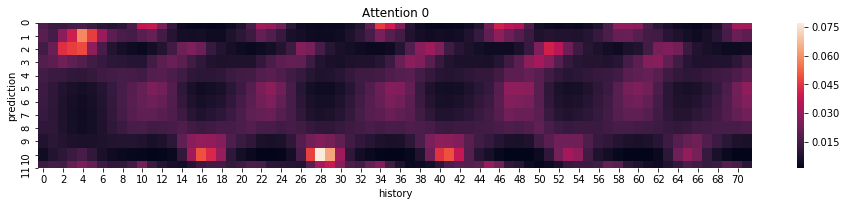

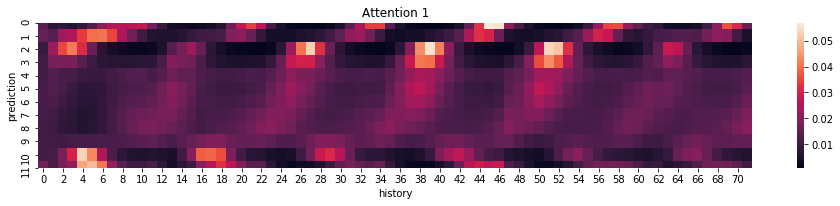

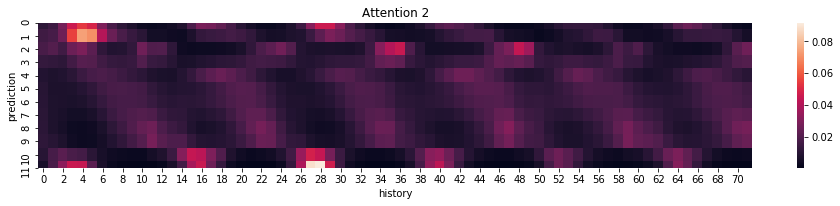

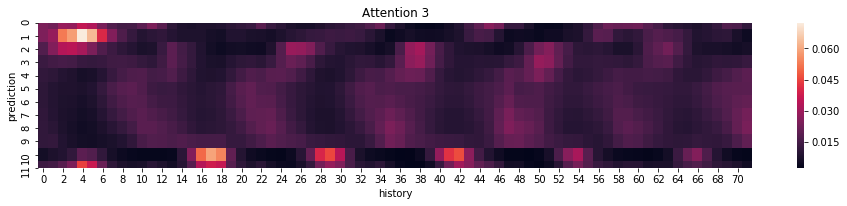

In [64]:
pred_idx = 200
enc_x = torch.tensor(series[pred_idx - enc_lens: pred_idx]).unsqueeze(0).float()
cat_x = torch.tensor(month[pred_idx-enc_lens: pred_idx + dec_lens]).unsqueeze(0).unsqueeze(2).long()
y_pred, attns = model.predict(enc_x, dec_lens, category_x=cat_x, use_move_scale=True, return_attns=True)
plot_attentions(attns)

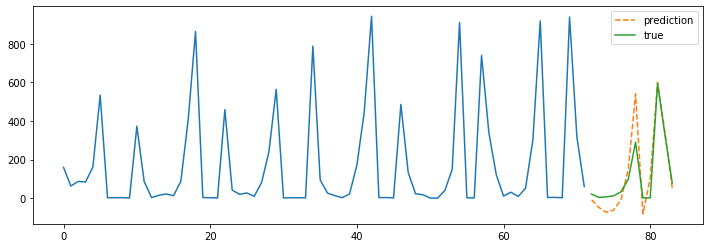

In [65]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
category_x = torch.tensor(val_set[k]['category_x']).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, category_x=category_x, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])

## 5. Simple WaveNet

In [66]:
dataset = SimpleWaveNetDataSet(series, enc_lens, dec_lens)
idxes = list(range(len(dataset)))
train_idxes, _idxes = walk_forward_split(idxes, enc_lens, dec_lens, test_size=n_test + n_val)
valid_idxes, test_idxes = walk_forward_split(_idxes, enc_lens, dec_lens, test_size=n_test)

trn_set = Subset(dataset, train_idxes)
val_set = Subset(dataset, valid_idxes)
test_set = Subset(dataset, test_idxes)
trn_ld = DataLoader(trn_set, batch_size=batch_size, shuffle=True, drop_last=False)
val_ld = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=False)
test_ld = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [67]:
hp = {
        'path': Path('.').resolve() / 'logs',
        'target_size': 20,
        'dilation': [1, 2, 4, 8, 16, 32, 64],
        'dropout': 0.2,
        'residual_channels': 72,
        'teacher_forcing_rate': 0.5,
        'use_move_scale': True,
    }

compile_params = {
    'optimizer': 'Adam',
    'lr': 0.001,
    'lr_scheduler': 'CosineAnnealingWarmRestarts',
    'lr_scheduler_kw': {'T_0': 5, 'T_mult': 10},
    'metric': 'RMSE',
    'loss_fn': 'MSELoss',
}

In [68]:
model = SimpleWaveNet(hp)
model.compile(**compile_params)
model.fit(epochs, trn_ld, val_ld, early_stopping=10, save_every_n_epochs=None, save_best_model=True)

batch 17 / 17, loss 0.947: 100%|██████████| 17/17 [00:01<00:00,  9.70it/s]


epoch 1 / 50: train loss 1.067 val loss 1.196 RMSE 181.624
create model path: C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs


batch 17 / 17, loss 0.822: 100%|██████████| 17/17 [00:01<00:00,  9.80it/s]


epoch 2 / 50: train loss 0.892 val loss 0.994 RMSE 167.396


batch 17 / 17, loss 0.706: 100%|██████████| 17/17 [00:01<00:00, 10.02it/s]


epoch 3 / 50: train loss 0.780 val loss 0.908 RMSE 159.354


batch 17 / 17, loss 0.679: 100%|██████████| 17/17 [00:01<00:00,  9.61it/s]


epoch 4 / 50: train loss 0.723 val loss 0.854 RMSE 154.019


batch 17 / 17, loss 0.833: 100%|██████████| 17/17 [00:01<00:00,  9.75it/s]


epoch 5 / 50: train loss 0.705 val loss 0.849 RMSE 153.384


batch 17 / 17, loss 0.561: 100%|██████████| 17/17 [00:01<00:00,  9.78it/s]


epoch 6 / 50: train loss 0.667 val loss 0.806 RMSE 148.009


batch 17 / 17, loss 0.523: 100%|██████████| 17/17 [00:01<00:00,  9.66it/s]


epoch 7 / 50: train loss 0.586 val loss 0.759 RMSE 144.321


batch 17 / 17, loss 0.506: 100%|██████████| 17/17 [00:01<00:00,  9.63it/s]


epoch 8 / 50: train loss 0.535 val loss 0.767 RMSE 143.291


batch 17 / 17, loss 0.387: 100%|██████████| 17/17 [00:01<00:00,  9.18it/s]


epoch 9 / 50: train loss 0.484 val loss 0.734 RMSE 139.829


batch 17 / 17, loss 0.351: 100%|██████████| 17/17 [00:01<00:00,  9.67it/s]


epoch 10 / 50: train loss 0.442 val loss 0.713 RMSE 138.264


batch 17 / 17, loss 0.679: 100%|██████████| 17/17 [00:01<00:00,  9.83it/s]


epoch 11 / 50: train loss 0.424 val loss 0.727 RMSE 139.353


batch 17 / 17, loss 0.293: 100%|██████████| 17/17 [00:01<00:00,  9.73it/s]


epoch 12 / 50: train loss 0.392 val loss 0.734 RMSE 138.258


batch 17 / 17, loss 0.349: 100%|██████████| 17/17 [00:01<00:00,  9.70it/s]


epoch 13 / 50: train loss 0.371 val loss 0.680 RMSE 131.545


batch 17 / 17, loss 0.308: 100%|██████████| 17/17 [00:01<00:00,  9.82it/s]


epoch 14 / 50: train loss 0.335 val loss 0.659 RMSE 129.455


batch 17 / 17, loss 0.339: 100%|██████████| 17/17 [00:01<00:00, 10.01it/s]


epoch 15 / 50: train loss 0.319 val loss 0.638 RMSE 126.385


batch 17 / 17, loss 0.284: 100%|██████████| 17/17 [00:01<00:00,  9.94it/s]


epoch 16 / 50: train loss 0.295 val loss 0.596 RMSE 121.678


batch 17 / 17, loss 0.249: 100%|██████████| 17/17 [00:01<00:00,  9.93it/s]


epoch 17 / 50: train loss 0.283 val loss 0.552 RMSE 115.734


batch 17 / 17, loss 0.406: 100%|██████████| 17/17 [00:01<00:00,  9.92it/s]


epoch 18 / 50: train loss 0.272 val loss 0.576 RMSE 118.585


batch 17 / 17, loss 0.487: 100%|██████████| 17/17 [00:01<00:00,  9.90it/s]


epoch 19 / 50: train loss 0.273 val loss 0.529 RMSE 111.244


batch 17 / 17, loss 0.258: 100%|██████████| 17/17 [00:01<00:00, 10.12it/s]


epoch 20 / 50: train loss 0.245 val loss 0.502 RMSE 107.639


batch 17 / 17, loss 0.202: 100%|██████████| 17/17 [00:01<00:00, 10.20it/s]


epoch 21 / 50: train loss 0.241 val loss 0.494 RMSE 107.054


batch 17 / 17, loss 0.261: 100%|██████████| 17/17 [00:01<00:00, 10.03it/s]


epoch 22 / 50: train loss 0.235 val loss 0.475 RMSE 104.337


batch 17 / 17, loss 0.239: 100%|██████████| 17/17 [00:01<00:00, 10.08it/s]


epoch 23 / 50: train loss 0.223 val loss 0.465 RMSE 103.158


batch 17 / 17, loss 0.286: 100%|██████████| 17/17 [00:01<00:00, 10.11it/s]


epoch 24 / 50: train loss 0.227 val loss 0.481 RMSE 104.394


batch 17 / 17, loss 0.182: 100%|██████████| 17/17 [00:01<00:00, 10.15it/s]


epoch 25 / 50: train loss 0.223 val loss 0.484 RMSE 104.901


batch 17 / 17, loss 0.191: 100%|██████████| 17/17 [00:01<00:00, 10.07it/s]


epoch 26 / 50: train loss 0.217 val loss 0.439 RMSE 100.213


batch 17 / 17, loss 0.169: 100%|██████████| 17/17 [00:01<00:00,  9.73it/s]


epoch 27 / 50: train loss 0.214 val loss 0.441 RMSE 99.699


batch 17 / 17, loss 0.204: 100%|██████████| 17/17 [00:01<00:00,  9.95it/s]


epoch 28 / 50: train loss 0.209 val loss 0.420 RMSE 96.394


batch 17 / 17, loss 0.168: 100%|██████████| 17/17 [00:01<00:00, 10.03it/s]


epoch 29 / 50: train loss 0.203 val loss 0.393 RMSE 92.396


batch 17 / 17, loss 0.191: 100%|██████████| 17/17 [00:01<00:00,  9.88it/s]


epoch 30 / 50: train loss 0.199 val loss 0.426 RMSE 97.361


batch 17 / 17, loss 0.199: 100%|██████████| 17/17 [00:01<00:00, 10.02it/s]


epoch 31 / 50: train loss 0.210 val loss 0.403 RMSE 95.616


batch 17 / 17, loss 0.215: 100%|██████████| 17/17 [00:01<00:00, 10.10it/s]


epoch 32 / 50: train loss 0.202 val loss 0.381 RMSE 91.328


batch 17 / 17, loss 0.166: 100%|██████████| 17/17 [00:01<00:00, 10.01it/s]


epoch 33 / 50: train loss 0.196 val loss 0.385 RMSE 90.447


batch 17 / 17, loss 0.168: 100%|██████████| 17/17 [00:01<00:00,  9.86it/s]


epoch 34 / 50: train loss 0.190 val loss 0.380 RMSE 91.596


batch 17 / 17, loss 0.225: 100%|██████████| 17/17 [00:01<00:00, 10.04it/s]


epoch 35 / 50: train loss 0.190 val loss 0.378 RMSE 88.980


batch 17 / 17, loss 0.227: 100%|██████████| 17/17 [00:01<00:00,  9.90it/s]


epoch 36 / 50: train loss 0.195 val loss 0.381 RMSE 89.276


batch 17 / 17, loss 0.172: 100%|██████████| 17/17 [00:01<00:00,  9.81it/s]


epoch 37 / 50: train loss 0.185 val loss 0.354 RMSE 86.077


batch 17 / 17, loss 0.168: 100%|██████████| 17/17 [00:01<00:00, 10.09it/s]


epoch 38 / 50: train loss 0.187 val loss 0.358 RMSE 86.604


batch 17 / 17, loss 0.144: 100%|██████████| 17/17 [00:01<00:00,  9.84it/s]


epoch 39 / 50: train loss 0.175 val loss 0.379 RMSE 89.652


batch 17 / 17, loss 0.177: 100%|██████████| 17/17 [00:01<00:00, 10.18it/s]


epoch 40 / 50: train loss 0.187 val loss 0.363 RMSE 86.981


batch 17 / 17, loss 0.147: 100%|██████████| 17/17 [00:01<00:00, 10.06it/s]


epoch 41 / 50: train loss 0.184 val loss 0.363 RMSE 86.664


batch 17 / 17, loss 0.160: 100%|██████████| 17/17 [00:01<00:00, 10.07it/s]


epoch 42 / 50: train loss 0.186 val loss 0.354 RMSE 86.029


batch 17 / 17, loss 0.144: 100%|██████████| 17/17 [00:01<00:00,  9.76it/s]


epoch 43 / 50: train loss 0.183 val loss 0.342 RMSE 84.063


batch 17 / 17, loss 0.161: 100%|██████████| 17/17 [00:01<00:00, 10.12it/s]


epoch 44 / 50: train loss 0.185 val loss 0.343 RMSE 84.629


batch 17 / 17, loss 0.165: 100%|██████████| 17/17 [00:01<00:00,  9.73it/s]


epoch 45 / 50: train loss 0.186 val loss 0.343 RMSE 84.769


batch 17 / 17, loss 0.190: 100%|██████████| 17/17 [00:01<00:00,  9.21it/s]


epoch 46 / 50: train loss 0.177 val loss 0.344 RMSE 84.498


batch 17 / 17, loss 0.181: 100%|██████████| 17/17 [00:01<00:00,  9.65it/s]


epoch 47 / 50: train loss 0.177 val loss 0.342 RMSE 84.195


batch 17 / 17, loss 0.142: 100%|██████████| 17/17 [00:01<00:00,  9.76it/s]


epoch 48 / 50: train loss 0.176 val loss 0.339 RMSE 83.532


batch 17 / 17, loss 0.206: 100%|██████████| 17/17 [00:01<00:00,  9.76it/s]


epoch 49 / 50: train loss 0.183 val loss 0.344 RMSE 84.190


batch 17 / 17, loss 0.167: 100%|██████████| 17/17 [00:01<00:00,  9.64it/s]


epoch 50 / 50: train loss 0.174 val loss 0.343 RMSE 84.068
best model save in C:\Users\evilp\project\Deep-Time-Series-Prediction\notebooks\logs\SimpleWaveNet_epoch_48_0.339.pkl


In [69]:
model.reload(model.best_model_path())
print(' - ' * 20)
print(f'train loss: {model.eval_cycle(trn_ld)[0]:.3f} '
      f'valid loss: {model.eval_cycle(val_ld)[0]:.3f} '
      f'test loss :{model.eval_cycle(test_ld)[0]:.3f} '
      f'test RMSE :{model.eval_cycle(test_ld)[1]:.3f}, ')
shutil.rmtree(hp['path'])

 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
train loss: 0.141 valid loss: 0.339 test loss :0.437 test RMSE :96.787, 


In [70]:
val_set[0].keys()

dict_keys(['enc_inputs', 'dec_outputs'])

In [ ]:
k = 0
h = 0

enc_seqs = val_set[k]['enc_inputs']
enc_inputs = torch.tensor(enc_seqs).unsqueeze(0)
category_x = torch.tensor(val_set[k]['category_x']).unsqueeze(0)
dec_outputs = val_set[k]['dec_outputs']
dec_step = dec_outputs.shape[0]
pred = model.predict(enc_inputs, dec_step, category_x=category_x, use_move_scale=True).squeeze().detach().numpy()
plot_prediction(enc_seqs[:, h], pred[:, h], dec_outputs[:, h])

## 6. Summary

| model | num of attention | RMSE(test) | loss(test) | loss(val) | loss(train)|
|:-:| :-: | :-:| :-:| :-:| :-:|
| SimpleSeq2Seq | / | 141.54 | 0.725|0.682|0.476|
| Seq2Seq| 0| 120.7| 0.571| 0.491| 0.279|
| Seq2Seq| 1| 113.9| 0.532| 0.427| 0.222|
| Seq2Seq| 4| 111.7 | 0.534| 0.422| 0.192|
| SimpleWaveNet| / | 84.5 | 0.355 | 0.237| 0.093|